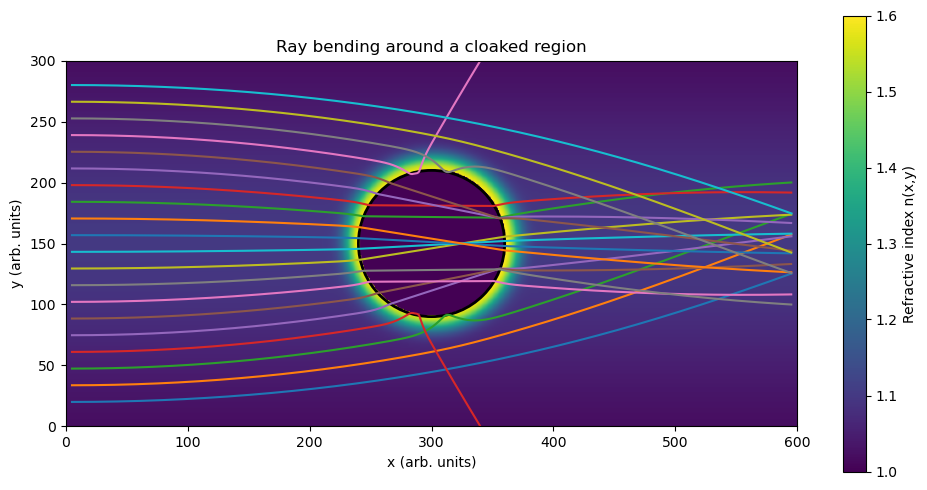

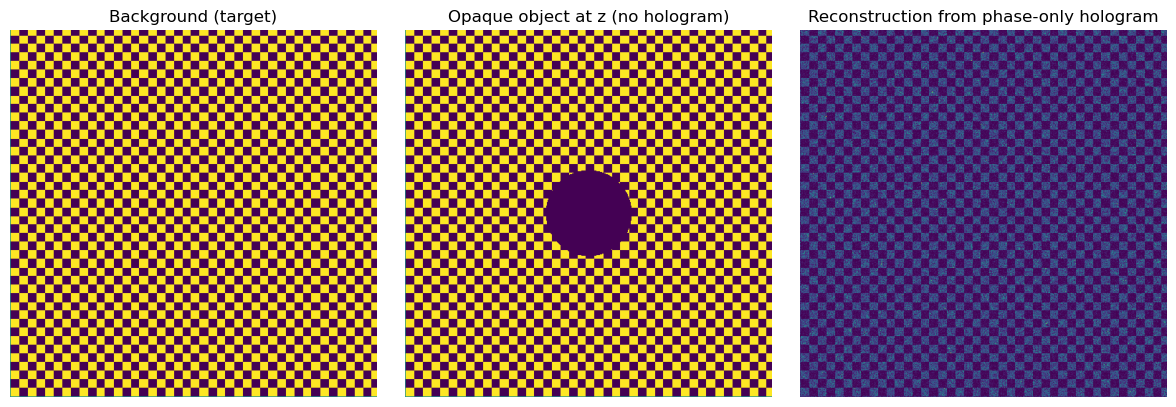

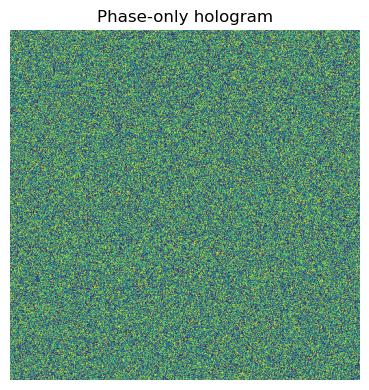

NameError: name 'holo_demo_code' is not defined

In [1]:
from textwrap import dedent
import subprocess, sys
import numpy as np
import matplotlib.pyplot as plt
import os

# Get the path to the desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

#ray_demo_code = dedent
import numpy as np
import matplotlib.pyplot as plt
import os

def make_grin_field(nx=600, ny=300, cloak_radius=60, cloak_center=(300,150), n0=1.0, dn=0.5):
   
    #Create a 2D gradient-index field n(x,y) that guides rays around a circular "cloaked" region.
    #We approximate a circular cloak by smoothly increasing refractive index near the boundary,
    #which steers rays (Fermat's principle) around the hole.
  
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)
    cx, cy = cloak_center
    R = np.sqrt((X - cx)**2 + (Y - cy)**2)

    # Smooth "wall" around the cloak: high-n ring that deflects rays
    wall = np.exp(-((R - cloak_radius)/12.0)**2)

    # Add a gentle background gradient so rays curve back to horizontal
    bg = 0.2*np.exp(-((Y - cy)/120.0)**2)

    n = n0 + dn*(wall + bg)
    # Inside the cloak: keep index near n0 (rays shouldn't enter)
    n[R < cloak_radius] = n0
    return n

def trace_rays(n, n_steps=1500, ds=0.5, start_y_vals=None):
    
    #Very simple paraxial ray tracer in an inhomogeneous medium:
    #d/ds(n * dr/ds) = grad(n)
    #We discretize with small steps and update directions by local gradient of n.
   
    ny, nx = n.shape
    gy, gx = np.gradient(n)

    if start_y_vals is None:
        start_y_vals = np.linspace(20, ny-20, 20)

    rays = []
    for y0 in start_y_vals:
        # start at left boundary, moving right
        x = 5.0
        y = float(y0)
        # unit direction (dx/ds, dy/ds); initial horizontal
        dx = 1.0
        dy = 0.0

        path = [(x, y)]
        for _ in range(n_steps):
            ix = int(np.clip(round(x), 0, nx-1))
            iy = int(np.clip(round(y), 0, ny-1))

            # Gradient forces rays to bend: d/ds(n*dir) = grad(n)
            # Approximate with: ddir/ds ≈ grad(n)/n - (dir · grad(n)) dir / n  (keeps |dir| ≈ 1)
            if n[iy, ix] <= 0:
                break

            ddir_x = gx[iy, ix] / n[iy, ix]
            ddir_y = gy[iy, ix] / n[iy, ix]
            dot = dx*ddir_x + dy*ddir_y
            ddir_x = ddir_x - dot*dx
            ddir_y = ddir_y - dot*dy

            dx += ds * ddir_x
            dy += ds * ddir_y
            norm = np.hypot(dx, dy) + 1e-12
            dx /= norm
            dy /= norm

            x += ds * dx
            y += ds * dy
            path.append((x, y))

            if x >= nx-5 or y <= 1 or y >= ny-1:
                break

        rays.append(np.array(path))
    return rays

def plot_scene(n, rays, cloak_center=(300,150), cloak_radius=60, title="Ray bending around a cloaked region"):
    ny, nx = n.shape
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(n, origin='lower', extent=[0, nx, 0, ny])
    ax.set_title(title)
    circle = plt.Circle(cloak_center, cloak_radius, fill=False, linewidth=2)
    ax.add_patch(circle)
    for r in rays:
        ax.plot(r[:,0], r[:,1])
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_xlabel("x (arb. units)")
    ax.set_ylabel("y (arb. units)")
    fig.colorbar(im, ax=ax, label="Refractive index n(x,y)")
    plt.tight_layout()
    return fig, ax

def main():
    n = make_grin_field()
    rays = trace_rays(n)
    fig, ax = plot_scene(n, rays)
    
    # Save to desktop
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    fig.savefig(os.path.join(desktop_path, "refraction_cloak_ray_demo.png"), dpi=150)
    plt.show()

if __name__ == "__main__":
    main()
#

#with open("/mnt/data/refraction_cloak_ray_demo.py", "w") as f:
    #f.write(ray_demo_code)

#holo_demo_code = dedent
import numpy as np
import matplotlib.pyplot as plt
import os

def ang_spec_propagate(u0, wavelength, dx, dy, z):
    ny, nx = u0.shape
    fx = np.fft.fftfreq(nx, d=dx)
    fy = np.fft.fftfreq(ny, d=dy)
    FX, FY = np.meshgrid(fx, fy)
    H = np.exp(1j * z * 2*np.pi * np.sqrt(np.maximum(0.0, (1.0/wavelength)**2 - FX**2 - FY**2)))
    U0 = np.fft.fft2(u0)
    Uz = U0 * H
    uz = np.fft.ifft2(Uz)
    return uz

def checkerboard(ny, nx, period=24):
    y = np.arange(ny)[:, None]
    x = np.arange(nx)[None, :]
    return 0.5*(1 + np.sign(np.sin(2*np.pi*x/period)*np.sin(2*np.pi*y/period)))

def phase_only(u):
    return np.exp(1j*np.angle(u))

def main():
    nx = ny = 512
    wavelength = 532e-9
    dx = dy = 8e-6
    z = 0.15

    bg = checkerboard(ny, nx, period=24)
    bg = (bg - bg.min())/(bg.max()-bg.min())

    yy, xx = np.indices((ny, nx))
    r = np.sqrt((xx - nx/2)**2 + (yy - ny/2)**2)
    obj_radius = 60
    obj_mask = (r <= obj_radius).astype(float)

    A_target = np.sqrt(bg)

    rng = np.random.default_rng(0)
    phi = rng.uniform(0, 2*np.pi, size=(ny, nx))
    U_target = A_target * np.exp(1j*phi)

    U0 = ang_spec_propagate(U_target, wavelength, dx, dy, -z)

    H = phase_only(U0)

    no_holo_scene = bg*(1.0 - obj_mask)

    recon = ang_spec_propagate(H, wavelength, dx, dy, z)
    recon_I = np.abs(recon)**2

    fig1, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(bg, origin='lower')
    axes[0].set_title("Background (target)")
    axes[1].imshow(no_holo_scene, origin='lower')
    axes[1].set_title("Opaque object at z (no hologram)")
    axes[2].imshow(recon_I, origin='lower')
    axes[2].set_title("Reconstruction from phase-only hologram")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    
    # Save to desktop
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    fig1.savefig(os.path.join(desktop_path, "hologram_camouflage_panels.png"), dpi=150)

    phase_img = (np.angle(H) + np.pi)/(2*np.pi)
    plt.figure(figsize=(4,4))
    plt.imshow(phase_img, origin='lower')
    plt.axis('off')
    plt.title("Phase-only hologram")
    plt.tight_layout()
    plt.savefig(os.path.join(desktop_path, "hologram_phase.png"), dpi=150)
    plt.show()

if __name__ == "__main__":
    main()

#with open("/mnt/data/hologram_camouflage_demo.py", "w") as f:
    #f.write(holo_demo_code)

# Execute to generate images
subprocess.run([sys.executable, "/mnt/data/refraction_cloak_ray_demo.py"], check=True)
subprocess.run([sys.executable, "/mnt/data/hologram_camouflage_demo.py"], check=True)

# Load and display the images from desktop
from PIL import Image
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
ray_img = Image.open(os.path.join(desktop_path, "refraction_cloak_ray_demo.png"))
holo_img = Image.open(os.path.join(desktop_path, "hologram_camouflage_panels.png"))
phase_img = Image.open(os.path.join(desktop_path, "hologram_phase.png"))

# Display the images
ray_img
import matplotlib.animation as animation   # NEW

def plot_scene(n, rays, cloak_center=(300,150), cloak_radius=60, 
               title="Ray bending around a cloaked region", animate=False):  # NEW animate arg
    ny, nx = n.shape
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(n, origin='lower', extent=[0, nx, 0, ny])
    ax.set_title(title)
    circle = plt.Circle(cloak_center, cloak_radius, fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_xlabel("x (arb. units)")
    ax.set_ylabel("y (arb. units)")
    fig.colorbar(im, ax=ax, label="Refractive index n(x,y)")
    plt.tight_layout()

    if not animate:   # original static version
        for r in rays:
            ax.plot(r[:,0], r[:,1])
        return fig, ax

#Animation version
    lines = [ax.plot([], [], lw=1.5)[0] for _ in rays]

    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    def update(frame):
        for line, r in zip(lines, rays):
            if frame < len(r):
                line.set_data(r[:frame,0], r[:frame,1])
            else:
                line.set_data(r[:,0], r[:,1])
        return lines

    max_len = max(len(r) for r in rays)
    ani = animation.FuncAnimation(fig, update, frames=max_len, 
                                  init_func=init, blit=True, interval=30)
    return fig, ax, ani   # return animation too
def main():
    n = make_grin_field()
    rays = trace_rays(n)
    fig, ax, ani = plot_scene(n, rays, animate=True)  # animate=True
# Save animation to desktop as mp4
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    ani.save(os.path.join(desktop_path, "ray_cloak_animation.mp4"), fps=30, dpi=150)
    plt.show()
